# 04 - Baseline Models

Comparação rápida de modelos baseline (LinearRegression, RandomForest, XGB opcional) com validação cruzada.



In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import sys
import os

# Adiciona o diretório raiz do projeto ao PYTHONPATH
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.data_ingestion import load_wine_dataframe
from src.data_processing import DataPreprocessor

In [2]:
HF_REPO = os.getenv("HF_DATASET_REPO", "henriquebap/wine-ml-dataset")
FILENAME = os.getenv("HF_DATASET_FILENAME", "WineQT.csv")

FEATURES = [
    "fixed acidity","volatile acidity","citric acid","residual sugar","chlorides",
    "free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"
]

df = load_wine_dataframe(repo_id=HF_REPO, filename=FILENAME)
pre = DataPreprocessor(feature_columns=FEATURES, target_column="quality")
df_p = pre.fit_transform(df)
X = df_p[FEATURES]
y = df_p["quality"]


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RF": RandomForestRegressor(n_estimators=300, random_state=42),
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    results.append({
        "model": name,
        "rmse_mean": -scores.mean(),
        "rmse_std": scores.std(),
    })

pd.DataFrame(results).sort_values("rmse_mean")


,model,rmse_mean,rmse_std
2,RF,0.638206,0.056437
1,Ridge,0.648645,0.045789
0,Linear,0.648671,0.045770


### RandomForest

In [3]:
rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 25, 30],
    'min_samples_split': [2, 15, 20],
    'min_samples_leaf': [1, 5, 8, 10],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(rf, param_dist)

grid_search.fit(x_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'bootstrap': [True, False], 'max_depth': [5, 25, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 5, ...], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [4]:
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 200}


In [6]:
rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)

In [7]:
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

In [8]:
rmse_rf = root_mean_squared_error(y_test, y_pred)
mape_rf = mean_absolute_percentage_error(y_test, y_pred)

In [9]:
print(rmse_rf)
print(mape_rf)

0.7025404222812827
0.10178419739744501


### LinearRegression

In [ ]:
lr = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

grid_search = GridSearchCV(lr, param_grid)

grid_search.fit(x_train, y_train)

,estimator,LinearRegression()
,param_grid,"{'copy_X': [True, False], 'fit_intercept': [True, False], 'positive': [True, False]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,fit_intercept,True


In [15]:
print(grid_search.best_params_)

lr = LinearRegression(**grid_search.best_params_)

{'copy_X': True, 'fit_intercept': True, 'positive': False}


In [16]:
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

In [17]:
rmse_lr = root_mean_squared_error(y_test, y_pred)
mape_lr = mean_absolute_percentage_error(y_test, y_pred)

In [18]:
print(rmse_lr)
print(mape_lr)

0.7224744038795153
0.10549062787433275


### Ridge

In [25]:
rd = Ridge(random_state=42)


param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['auto', 'saga', 'lsqr'],
    'tol': [1e-3, 1e-4, 1e-5],
    'positive': [True, False]
}

grid_search = GridSearchCV(rd, param_grid)

grid_search.fit(x_train, y_train)

c:\Users\felip\Desktop\wine-ml-app\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\felip\Desktop\wine-ml-app\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\felip\Desktop\wine-ml-app\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\felip\Desktop\wine-ml-app\.venv\Lib\site-packages\

,estimator,Ridge(random_state=42)
,param_grid,"{'alpha': [0.001, 0.01, ...], 'fit_intercept': [True, False], 'positive': [True, False], 'solver': ['auto', 'saga', ...], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,10


In [26]:
print(grid_search.best_params_)

rd = Ridge(**grid_search.best_params_)

{'alpha': 10, 'fit_intercept': True, 'positive': False, 'solver': 'lsqr', 'tol': 0.001}


In [27]:
rd.fit(x_train, y_train)

y_pred = rd.predict(x_test)

In [28]:
rmse_rd = root_mean_squared_error(y_test, y_pred)
mape_rd = mean_absolute_percentage_error(y_test, y_pred)

In [29]:
print(rmse_rd)
print(mape_rd)

0.7225755098852275
0.10556844761925198


### Comparacao

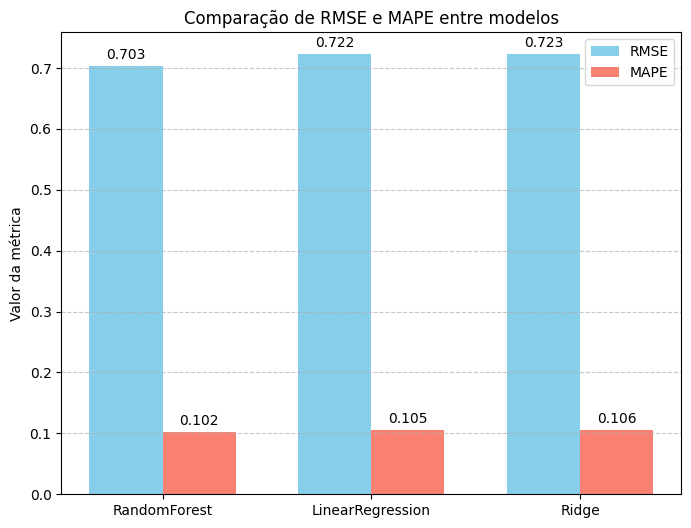

In [30]:
import matplotlib.pyplot as plt

modelos = ["RandomForest", "LinearRegression", "Ridge"]

rmse = [rmse_rf, rmse_lr, rmse_rd]
mape = [mape_rf, mape_lr, mape_rd]

x = np.arange(len(modelos))  # posições dos modelos
largura = 0.35  # largura das barras

fig, ax = plt.subplots(figsize=(8, 6))

# Barras
barras_rmse = ax.bar(x - largura/2, rmse, largura, label="RMSE", color="skyblue")
barras_mape = ax.bar(x + largura/2, mape, largura, label="MAPE", color="salmon")

# Adiciona rótulos em cima das barras
ax.bar_label(barras_rmse, fmt="%.3f", padding=3)
ax.bar_label(barras_mape, fmt="%.3f", padding=3)

# Ajustes visuais
ax.set_ylabel("Valor da métrica")
ax.set_title("Comparação de RMSE e MAPE entre modelos")
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()